# Exoplanets HW3 
## Steven Stetzler and Miles Currie

### Problem 1

Install Rebound

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib import rcParams
import sys
from scipy.optimize import minimize
import emcee
from astropy import units as u
from scipy.optimize import curve_fit
import warnings

In [2]:
warnings.filterwarnings("ignore")

rcParams['figure.figsize'] = [12, 10]
rcParams['font.size'] = 18

### Problem 2
Look up the parameters of the planet system GJ 876.  Assume the planets’ orbits lie in a plane, and vary the inclination of the system.  At what inclination does the system become unstable after 1000 orbits of the inner planet? What upper limit does this place on the planets’ masses?  At what inclination would the planets be seen to transit?  What lower limit does this place on the planets’ masses?


### From [Rivera et al. (2010)](https://iopscience.iop.org/article/10.1088/0004-637X/719/1/890/pdf):
<img src="GJ876_planet_params.png">
<img src="GJ876_stellar_params.png">

In [3]:
class Planet():
    def __init__(self, P, m, a, K, e, omega, mean_anomoly, i):
        self.P = P 
        self.m = m
        self.a = a
        self.K = K
        self.e = e
        self.omega = omega
        self.mean_anomoly = mean_anomoly
        self.i = i
        
    def copy(self):
        return Planet(self.P, self.m, self.a, self.K, self.e, self.omega, self.mean_anomoly, self.i)

In [4]:
# 1 year = 365 days is 1 / (2 pi) yr / (2 pi)
# 365 * DAYS_TO_YEARS_OVER_2_PI = 1 / (2 * pi)
DAYS_TO_YEARS_OVER_2_PI = 2 * np.pi / (365.25)

DAYS_TO_YEARS = 1. / 365.25

DEG_TO_RAD = np.pi / 180.
RAD_TO_DEG = 180 / np.pi

M_JUPITER_TO_M_EARTH = 317.828
M_SUN_TO_M_EARTH = 332948.6
M_EARTH_TO_M_SUN = 1. / M_SUN_TO_M_EARTH
M_JUPITER_TO_M_SUN = 1. / 1047.58
REF_INCLINATION = 59 * DEG_TO_RAD
M_STAR = 0.32

In [5]:
def build_sim_from_planets(planets, units=('yr', 'AU', 'Msun')):
    sim = rebound.Simulation()
    
    sim.units = units
    
    # Add center star
    if "Mearth" in units:
        sim.add(m=M_STAR * M_SUN_TO_M_EARTH)
    elif "Mjupiter" in units:
        sim.add(m=M_STAR / M_JUPITER_TO_M_SUN)
    else:
        sim.add(m=M_STAR)
        
    # Add all planets
    for planet in planets: 
        sim.add(m=planet.m, P=planet.P, e=planet.e, M=planet.mean_anomoly, omega=planet.omega, inc=planet.i)
    
    # convert to center of mass coordinates
    sim.move_to_com()
    
    return sim

In [6]:
def run_simulation(planets, integration_time, plot=False, num_steps=10, archive_interval=None, 
                   units=('yr', 'AU', 'Msun'), dt=1e-3, archive_file_name="archive.bin", **kwargs):   
    
    sim = build_sim_from_planets(planets, units=units)
    
    sim.dt = dt 
    sim.integrator = "whfast"
    
    if archive_interval is not None:
        sim.automateSimulationArchive(archive_file_name, interval=archive_interval, deletefile=True)

    sim.move_to_com()
    
    if plot:
        for i in range(num_steps):
            sim.integrate(sim.t + integration_time / num_steps)
            fig = rebound.OrbitPlot(sim, color=True, unitlabel="[AU]")
            if "years" in units:
                fig.suptitle(f"{sim.t:0.2f} year" + f" {sim.t / sim.particles[1].P:0.2f} orbits")
            else:
                fig.suptitle(f"{sim.t:0.2f} {sim.units['time']} {sim.t / sim.particles[1].P:0.2f} orbits")
            display(fig)
            plt.close(fig)
            clear_output(wait=True)
        display(fig)
    else:
        sim.integrate(integration_time)
        
    return sim

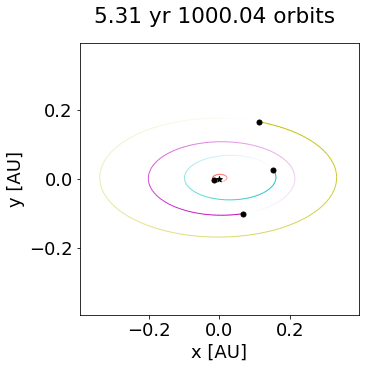

In [7]:
planets = [
    Planet(1.937780 * DAYS_TO_YEARS, 
           6.83 * M_EARTH_TO_M_SUN, 
           0.02080665, 
           6.56, 
           0.207, 
           234 * DEG_TO_RAD, 
           355 * DEG_TO_RAD,
           REF_INCLINATION),
    Planet(30.0881 * DAYS_TO_YEARS,
           0.7142 * M_JUPITER_TO_M_SUN, 
           0.129590, 
           88.34, 
           0.25591, 
           48.76 * DEG_TO_RAD, 
           294.59 * DEG_TO_RAD,
           REF_INCLINATION),
    Planet(61.1166 * DAYS_TO_YEARS, 
           2.2756 * M_JUPITER_TO_M_SUN, 
           0.208317, 
           214, 
           0.0324, 
           50.3 * DEG_TO_RAD, 
           325.7 * DEG_TO_RAD,
           REF_INCLINATION),
    Planet(124.26 * DAYS_TO_YEARS, 
           14.6 * M_EARTH_TO_M_SUN, 
           0.3343, 
           3.42, 
           0.055, 
           239 * DEG_TO_RAD, 
           335 * DEG_TO_RAD,
           REF_INCLINATION)
]

run_simulation(planets, planets[0].P * 1000, plot=True)

In [8]:
def new_mass_estimate(m, m_star, i, i_new):
    t = 0
    max_iter = 100

    A = m * np.sin(i) / (m_star + m)**(2/3)
    m_new = m
    for t in range(max_iter):
        B = (m_star + m_new)**(2/3) / np.sin(i_new)
        m_new = A * B
    
    return m_new

In [9]:
def modify_masses(planets, inclination, verbose=True, **kwargs):
    modified_masses = [new_mass_estimate(planet.m, M_STAR, REF_INCLINATION, inclination) for planet in planets]
    
    ret_planets = [planet.copy() for planet in planets]
    
    if verbose:
        print("Modified masses:")
        
    for ret_planet, modified_mass in zip(ret_planets, modified_masses):
        if verbose:
            print(f"  {ret_planet.m} --> {modified_mass}")
        ret_planet.m = modified_mass
    
    return ret_planets

In [10]:
def adjust_inclination(planets, inclination, **kwargs):
    planets = modify_masses(planets, inclination, **kwargs)
    
    for planet in planets:
        planet.i = inclination
    
    return planets

In [11]:
def run_simulation_at_inclination(planets, inclination, integration_time, **kwargs):
    sim_planets = adjust_inclination(planets, inclination, **kwargs)
    
    return run_simulation(sim_planets, integration_time, **kwargs)

In [12]:
# Check if any of the orbits are within the Hill radius of one another
# Return True if orbits are unstable
# Return False if orbits are stable
def orbits_unstable(particles):
    positions = np.array([np.array([particle.x, particle.y, particle.z]) for particle in particles])
    distances = np.zeros((len(particles), len(particles)))
    
    def hill_spheres_intersect():
        r_H_list = [particle.a * (1-particle.e) * (particle.m / particles[0].m) for particle in particles[1:]]

        for i in range(len(particles)):
            for j in range(len(particles)):
                distances[i, j] = np.sqrt(np.sum((positions[i] - positions[j])**2))

        for i, (distance, r_H) in enumerate(zip(distances[1:], r_H_list)):
            distance_minus_r_H = distance - r_H
            negative_indices = np.where(distance_minus_r_H < 0)[0]
            negative_indices = [j for j in negative_indices if j != i + 1]
            if len(negative_indices) > 0:
                return True
            
        return False
    
    # Check if each planet's distance from the star is less than another planet's semi-major axis
    def orbits_cross():        
        semi_major_axes = [particle.a for particle in particles[1:]]
        
        semi_major_axes_sorted = np.sort(semi_major_axes)
        
        return not np.array_equal(semi_major_axes, semi_major_axes_sorted)
    
    return hill_spheres_intersect() or orbits_cross()

# Check all checkpoints in a simulation to see if the orbits are unstable at any point
def simulation_unstable():
    sa = rebound.SimulationArchive("archive.bin")
    return np.any([orbits_unstable(sim.particles) for sim in sa])

### At what inclination does the system become unstable after 1000 orbits of the inner planet?

In [13]:
inclinations = np.linspace(0.01, np.pi/2, 200)
stability_checks = []
for i, inclination in enumerate(inclinations):
    sim = run_simulation_at_inclination(planets, 
                                        inclination, 
                                        planets[0].P * 1000, 
                                        verbose=False,
                                        archive_interval=1e-2)
    stability_checks.append(simulation_unstable())
    print(f"{100 * (i + 1) / len(inclinations)}% done   ", end="\r")
    sys.stdout.flush()

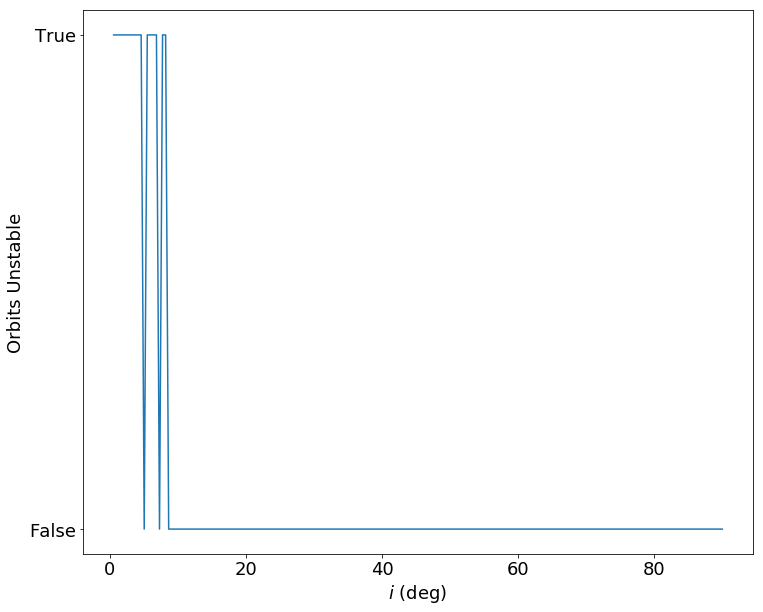

In [14]:
plt.plot(inclinations * RAD_TO_DEG, stability_checks)
plt.xlabel(r"$i$ (deg)")
plt.yticks([0, 1], ["False", "True"])
plt.ylabel("Orbits Unstable")
plt.show()

In [15]:
first_unstable_inclination = np.max(inclinations[stability_checks])
print(f"Orbits unstable after 1000 orbits starting at i = {first_unstable_inclination * RAD_TO_DEG :0.2f} (degrees)")

Orbits unstable after 1000 orbits starting at i = 8.21 (degrees)


### What upper limit does this place on the planets’ masses?  

In [16]:
# Adjust the masses of the planets to adjust for the inclination at which orbits start to become unstable
first_unstable_masses = [planet.m for planet in modify_masses(planets, first_unstable_inclination, verbose=False)]
for i, mass in enumerate(first_unstable_masses):
    print(f"Planet {i + 1} Mass <= {mass:0.2e} (M_sun) = {mass * M_SUN_TO_M_EARTH:0.2e} (M_earth) = {mass / M_JUPITER_TO_M_SUN:0.2e} (M_jupiter)")
    

Planet 1 Mass <= 1.23e-04 (M_sun) = 4.10e+01 (M_earth) = 1.29e-01 (M_jupiter)
Planet 2 Mass <= 4.12e-03 (M_sun) = 1.37e+03 (M_earth) = 4.32e+00 (M_jupiter)
Planet 3 Mass <= 1.33e-02 (M_sun) = 4.44e+03 (M_earth) = 1.40e+01 (M_jupiter)
Planet 4 Mass <= 2.63e-04 (M_sun) = 8.77e+01 (M_earth) = 2.76e-01 (M_jupiter)


### At what inclination would the planets be seen to transit?  What lower limit does this place on the planets’ masses?

![lower_limit_diagram.png](lower_limit_diagram.png)

If we assume all planets are in the same plane and the outer-most planet is a grazing transit (absolute limit of transit detection), then the inclination of that orbit can be found from geometry and the above diagram:
$$
i = \cos^{-1}\left(\frac{R_{star} + R_{planet}}{a_{planet}}\right)
$$
If we assume $R_{planet} << R_{star}$, then we can say:
$$
i \approx \cos^{-1}\left(\frac{R_{star}}{a_{planet}}\right)
$$

In [17]:
R_SUN_TO_AU = 0.00465
R_star = 0.3 * R_SUN_TO_AU
a_planet = planets[0].a

i_upper_limit = np.arccos(R_star / a_planet)
print(f"Upper limit on inclination = {i_upper_limit * RAD_TO_DEG:0.2f}")

# Adjust the masses of the planets to adjust for the inclination at which orbits start to become unstable
mass_lower_limits = [planet.m for planet in modify_masses(planets, i_upper_limit, verbose=False)]
for i, mass in enumerate(mass_lower_limits):
    print(f"Planet {i + 1} Mass >= {mass:0.2e} (M_sun) = {mass * M_SUN_TO_M_EARTH:0.2e} (M_earth) = {mass / M_JUPITER_TO_M_SUN:0.2e} (M_jupiter)")


Upper limit on inclination = 86.16
Planet 1 Mass >= 1.76e-05 (M_sun) = 5.87e+00 (M_earth) = 1.85e-02 (M_jupiter)
Planet 2 Mass >= 5.86e-04 (M_sun) = 1.95e+02 (M_earth) = 6.13e-01 (M_jupiter)
Planet 3 Mass >= 1.86e-03 (M_sun) = 6.21e+02 (M_earth) = 1.95e+00 (M_jupiter)
Planet 4 Mass >= 3.77e-05 (M_sun) = 1.25e+01 (M_earth) = 3.95e-02 (M_jupiter)


### Problem 3
Compute the radial velocity of the star, and then fit this RV with four Keplerian orbits. How big are the residuals?  How does this compare to typical RV errors?

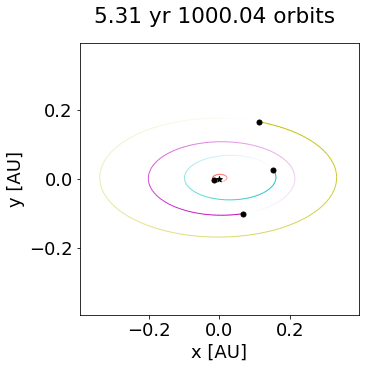

In [18]:
# Run the simulation for 1000 orbits of the inner planet, taking snapshots along the way
sim = run_simulation(planets, planets[0].P * 1e3, plot=True, num_steps=10, archive_interval=1e-2,
                     default_units=True, dt=1e-3)

In [19]:
# Open simulation archive and get radial velocities of the star
sa = rebound.SimulationArchive("archive.bin")
radial_velocities = []
# In yr
times = np.array([sim.t for sim in sa])
# In AU / yr
rv = np.array([sim.particles[0].vz for sim in sa])
# Set RV errors to be 1 so they are ignored in chi-squared computation
rv_err = np.ones(len(times))

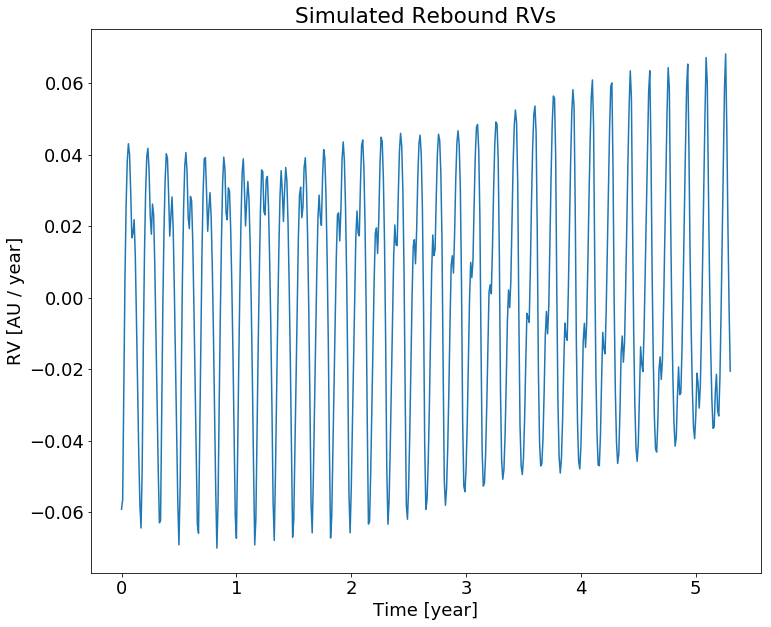

In [20]:
plt.plot(times, rv)
plt.title("Simulated Rebound RVs")
plt.xlabel("Time [year]")
plt.ylabel("RV [AU / year]")
plt.show()

In [21]:
# Construct a model for radial velocity data given an orbital configuration
# planet_parameters is a vector (or list) the periods, eccentricities, and times of periastron passage for 
# planets: planet_parameters = [P_1, e_1, t_p_1, P_2, e_2, t_p_2, ..., P_n, e_n, t_p_n]
def model_rv(time, rv_data, rv_errors, planet_parameters):
    # Computes the mean anomoly of an orbit at time t given the period P and time of perastron t_p
    def compute_mean_anomoly(t, P, t_p):
        M = (2 * np.pi / P) * (t - t_p)
        return M

    # Computes the eccentric anomoly from the mean anomoly and the ecentricity
    # Solve M = E - e sin(E) using Newton's Method
    def compute_eccentric_anomoly(M, e):
        # find where g = 0
        def g(E, e, M):
            return E - e * np.sin(E) - M

        def dgdE(E, e):
            return 1 - e * np.cos(E)

        # Trick for initial guess
        E = M + 0.85 * e * np.sign(np.sin(M))

        # Run algorithm until convergence or until max number of iterations
        converged = False
        max_iter = 100
        i = 0

        while (not converged) and (i < max_iter):
            update_E = - g(E, e, M) / dgdE(E, e)
            E = E + update_E

            converged = np.all(np.abs(update_E) < 1e-9)
            i = i + 1
            
        return E

    def compute_f(e, E):
        return 2 * np.arctan(((1 + e) / (1 - e))**0.5 * np.tan(E / 2))
    
    num_planets = int(len(planet_parameters) / 3)
    num_rows = 2 * num_planets + 1
    num_cols = len(time)
    F = np.zeros((num_rows, num_cols))
    
    # For each planet in the model
    for i in range(num_planets):
        P, e, t_p = planet_parameters[3 * i], planet_parameters[3 * i + 1], planet_parameters[3 * i + 2]
        
        M = compute_mean_anomoly(time, P, t_p)
        E = compute_eccentric_anomoly(M, e)
        f = compute_f(e, E)

        F[2 * i, :] = np.cos(f)
        F[2 * i + 1, :] = np.sin(f)
    
    F[-1, :] = 1

    W = np.eye(num_cols) / rv_errors
    
    eps = np.linalg.inv(F @ W @ F.T)
    
    beta = rv_data @ W @ F.T @ eps
    
    modelled_rvs = beta @ F
    return modelled_rvs

In [22]:
# Chi-Squared function between data and model for that data with associated errors
def chi_sq(data, data_err, model):
    return np.sum((data - model)**2 / data_err**2)

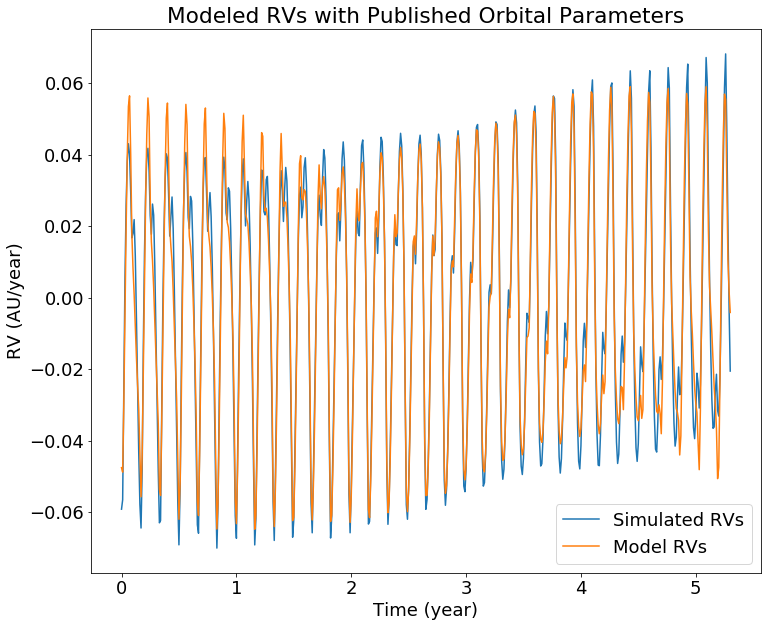

In [23]:
# Create initial guess for parameters
# We use the period and eccentricity as measured by Rivera et al.
x0 = np.hstack([[planet.P, planet.e, 0] for planet in planets])

modelled_rvs = model_rv(times, rv, rv_err, x0)

plt.title("Modeled RVs with Published Orbital Parameters")
plt.plot(times, rv, label="Simulated RVs")
plt.plot(times, modelled_rvs, label="Model RVs")
plt.xlabel("Time (year)")
plt.ylabel("RV (AU/year)")
plt.legend()
plt.show()

In [24]:
def f(x, times, rv, rv_err):
    # Bounds on periods and eccentricities
    periods = x[0::3]
    eccentricites = x[1::3]

    # 0 < e < 1, 0 < P
    if np.any(eccentricites < 0) or np.any(eccentricites > 1) or np.any(periods < 0):
        return 1e22
    else:
        return chi_sq(rv, rv_err, model_rv(times, rv, rv_err, x))

In [25]:
# Chi-Squared at initial guess
print(f(x0, times, rv, rv_err))

0.027492701341996335


In [26]:
# Optimize over parameter values, using published values as an initial guess
res = minimize(lambda x : f(x, times, rv, rv_err), x0)

In [27]:
# Minimized Chi-Squared
print(f(res.x, times, rv, rv_err))

0.0038674031080413378


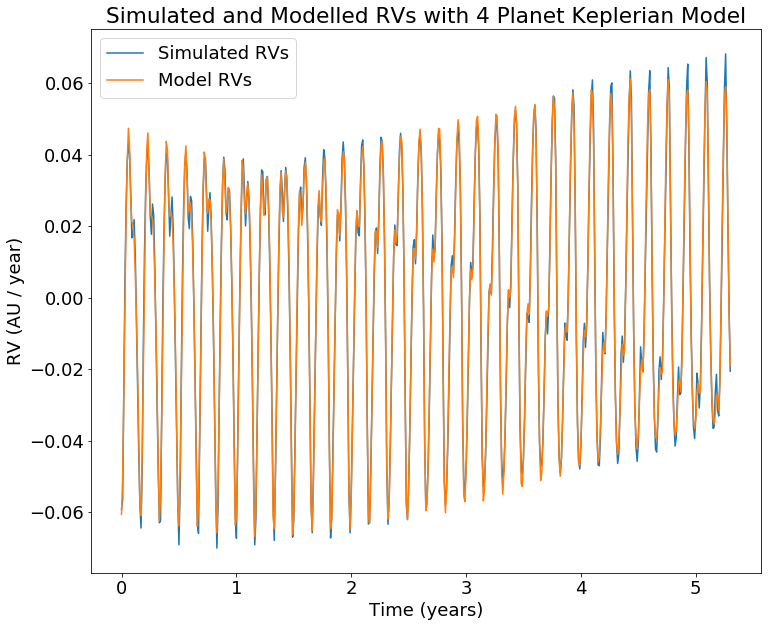

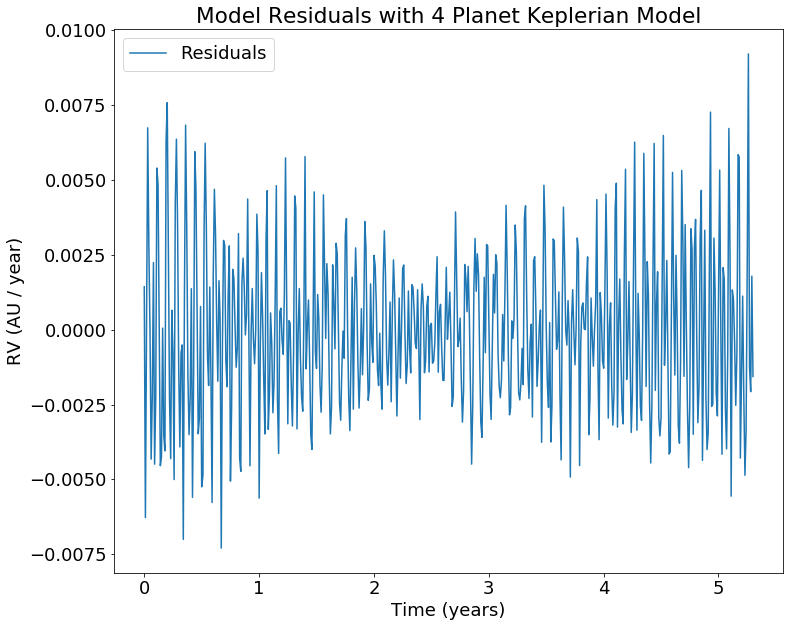

chi^2 = 0.00387

Planet 1:
    P = 0.006 (year)
    e = 0.827
    t_p = 0.009 (year)

Planet 2:
    P = 0.083 (year)
    e = 0.177
    t_p = -0.006 (year)

Planet 3:
    P = 0.167 (year)
    e = 0.072
    t_p = -0.034 (year)

Planet 4:
    P = 0.338 (year)
    e = 0.806
    t_p = 0.040 (year)

Residuals:
    Average = 5.92e-18
    Standard Deviation = 2.70e-03


In [28]:
# Plot the best model along with the data
model_rvs = model_rv(times, rv, rv_err, res.x)

plt.plot(times, rv, label="Simulated RVs")
plt.plot(times, model_rvs, label="Model RVs")
plt.title("Simulated and Modelled RVs with 4 Planet Keplerian Model")
plt.xlabel("Time (years)")
plt.ylabel("RV (AU / year)")
plt.legend()
plt.show()

residuals = rv - model_rvs

plt.plot(times, rv - model_rvs, label="Residuals")
plt.title("Model Residuals with 4 Planet Keplerian Model")
plt.xlabel("Time (years)")
plt.ylabel("RV (AU / year)")
plt.legend()
plt.show()

print(f"chi^2 = {chi_sq(rv, rv_err, model_rvs):0.5f}")
for i in range(int(len(res.x) / 3)):
    print(f"\nPlanet {i + 1}:")
    print(f"    P = {res.x[3 * i]:0.3f} (year)")
    print(f"    e = {res.x[3 * i + 1]:0.3f}")
    print(f"    t_p = {res.x[3 * i + 2]:0.3f} (year)")
    
print("\nResiduals:")
print(f"    Average = {np.mean(residuals):0.2e}")
print(f"    Standard Deviation = {np.std(residuals):0.2e}")

In [29]:
residuals_m_per_s = (np.std(residuals) * u.AU / u.year).to(u.m / u.s)
print(f"RMS of Residuals: {residuals_m_per_s:0.2e}")

RMS of Residuals: 1.28e+01 m / s


Compared with the published RMS of the residuals of $2.9604~\text{m}~\text{s}^{-1}$, the residuals of the 4 Keplerian RV fit are about an order of magnitude larger, at $12.8~\text{m}~\text{s}^{-1}$.

### Problem 4
Look at REBOUND TTV example.  Make a plot of the TTVs of GJ 876 c over 4 years (assuming edge-on, so that planet would transit).  Measure amplitude and period of the sinusoidal variation component.  How does it change if you vary the mass of GJ 876 b downward and upward by a factor of 2?

In [30]:
# Compute the TTVs of planet 3 in planets list
# switching the mass of planet 2 in the planets list
# with the mass given. Simulations are run at the 
# inclination given
def TTV(planets, inclination, planet_b_mass, verbose=False):
    planets = [planet.copy() for planet in planets]

    # Adjust planet mass
    planets[1].m = planet_b_mass

    # Adjust planets (and their masses) for the given inclination
    planets = adjust_inclination(planets, inclination, verbose=verbose)
    
    # Build simulation from planets list
    sim = build_sim_from_planets(planets)
    sim.dt = 1e-5

    p = sim.particles

    # 2 = GJ 876 b
    # 3 = GJ 876 c
    planet_choice = 3
    # Number of transits to compute
    N = int(4 / p[planet_choice].P) * 10
    # Integration time step, half of a period
    time_step = 0.5 * p[planet_choice].P
    
    transittimes = np.zeros(N)
    
    i = 0
    while i < N:
        y_old = p[planet_choice].y - p[0].y
        t_old = sim.t
        # check for transits every time_step
        sim.integrate(sim.t + time_step)
        t_new = sim.t
        # sign changed (y_old*y<0), planet in front of star (x>0)
        if (y_old * (p[planet_choice].y - p[0].y) < 0.) and (p[planet_choice].x - p[0].x > 0.):
            while t_new - t_old > 1e-7:   # bisect until precision of 1e-7 reached
                if y_old * (p[planet_choice].y - p[0].y) < 0.:
                    t_new = sim.t
                else:
                    t_old = sim.t
                sim.integrate( (t_new + t_old) / 2.)
            transittimes[i] = sim.t
            i += 1
            # integrate a little to be past transit
            sim.integrate(sim.t + time_step / 10)

    A = np.vstack([np.ones(N), range(N)]).T
    c, m = np.linalg.lstsq(A, transittimes)[0]

    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    ax.set_xlim([0, N])
    ax.set_xlabel("Transit number")
    ax.set_ylabel("TTV [hours]")

    YEARS_TO_HOURS = 24. * 365
    
    TTV_detrended = (transittimes - m * np.array(range(N)) - c) * YEARS_TO_HOURS
    ax.set_ylim([1.2 * min(TTV_detrended), 1.2 * max(TTV_detrended)])
    plt.scatter(range(N), TTV_detrended)
    plt.show()
    
    return transittimes, TTV_detrended

In [31]:
def fit_sinusoid(x, y, p0=None):
    def func(x, A, P, w):
        return A * np.sin(x / P * 2 * np.pi + w)
    
    res, _ = curve_fit(func, x, y, p0=p0)
    
    return res[0], res[1], res[2], lambda x : res[0] * np.sin(x / res[1] * 2 * np.pi + res[2])

def measure_amplitude_and_period(x, y, p0=None):
    A, P, _, model = fit_sinusoid(x, y, p0=p0)

    _x_range = np.linspace(np.min(x), np.max(x), 1000)
    print(f"Amplitude of TTVs = {np.abs(A):0.2f} (hours)")
    print(f"Period of TTVs = {P:0.2f} (years)")
    
    plt.scatter(x, y, label="TTVs")
    plt.scatter(_x_range, model(_x_range), label="Sinusoidal Component")
    
    plt.xlabel("Time [years]")
    plt.ylabel("TTV [hours]")

    plt.legend()
    plt.show()

In [32]:
planets[2].P

0.16732813141683778

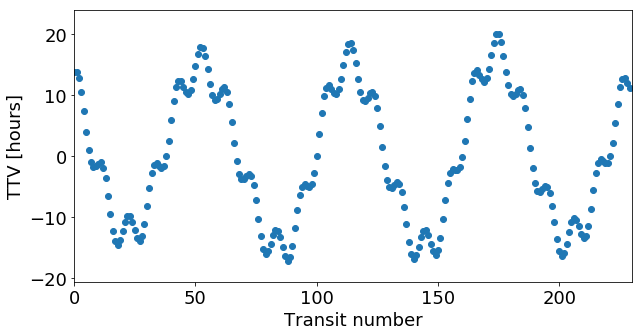

In [33]:
times, TTVs = TTV(planets, np.pi/2, planets[1].m)

Amplitude of TTVs = 14.95 (hours)
Period of TTVs = 10.09 (years)


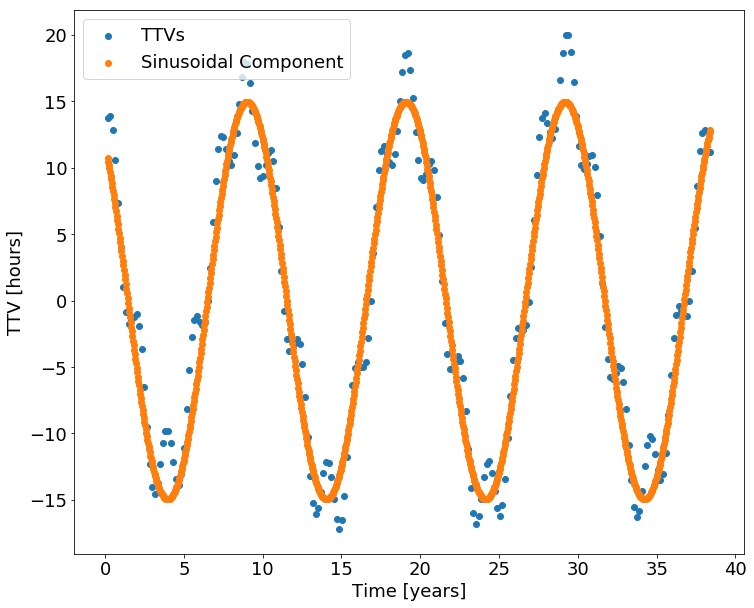

In [34]:
measure_amplitude_and_period(times, TTVs, p0=[np.max(TTVs), 10, 0])

The sinusoidal component of th TTVs present in the system have an amplitude of $14.95$ hours and a period of $10.09$ years.

### Double mass of GJ 876 b

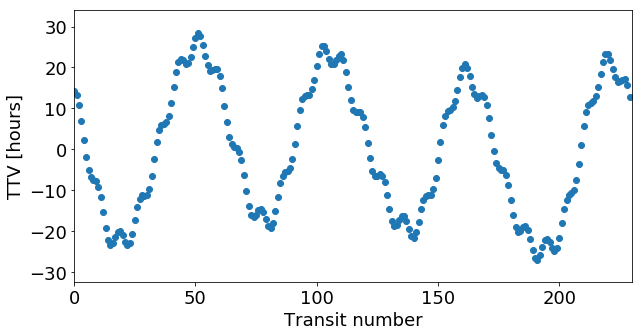

In [35]:
times, TTVs = TTV(planets, np.pi/2, 2 * planets[1].m)

Amplitude of TTVs = 21.32 (hours)
Period of TTVs = 9.57 (years)


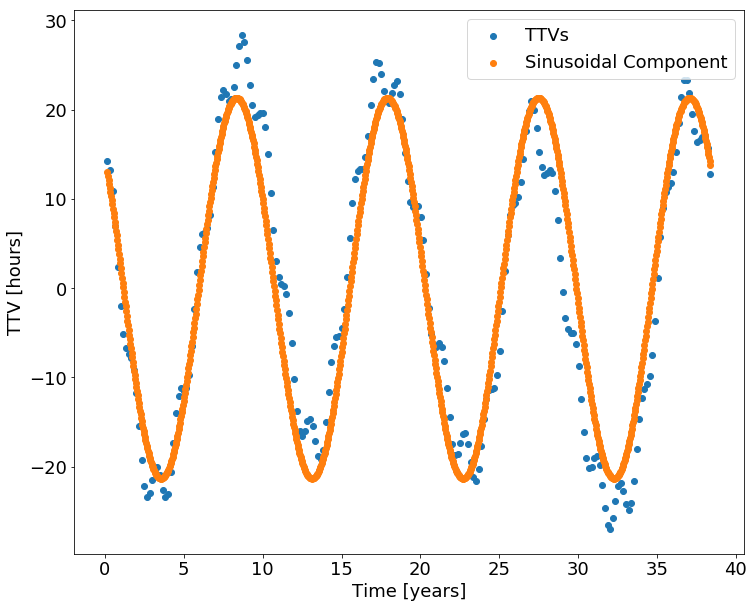

In [36]:
measure_amplitude_and_period(times, TTVs, p0=[np.max(TTVs), 10, 0])

Doubling the mass of GJ 876 b incresed the amplitude from $14.95$ to $21.32$ hours, increasing by a factor of $1.43$. The period of the TTVs decreased from $10.09$ to $9.57$ years, decreasing by a factor of $0.95$.

### Halve the mass of GJ 876 b

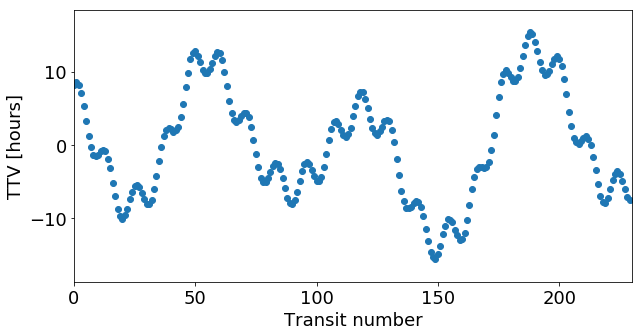

In [37]:
times, TTVs = TTV(planets, np.pi/2, 0.5 * planets[1].m)

Amplitude of TTVs = 8.96 (hours)
Period of TTVs = 11.06 (years)


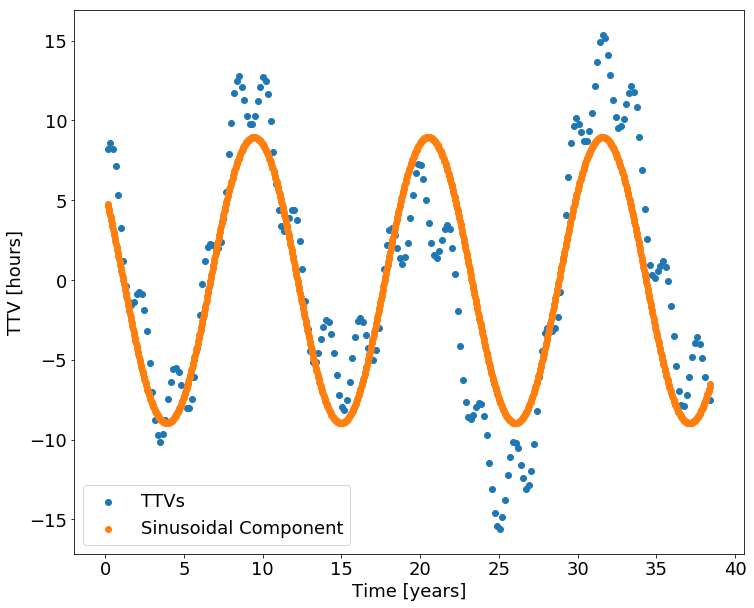

In [38]:
measure_amplitude_and_period(times, TTVs, p0=[np.max(TTVs), 10, 0])

Halving the mass of GJ 876 b decreased the amplitude from $14.95$ to $8.96$ hours, decreasing by a factor of $0.60$. The period of the TTVs increased from $10.09$ to $11.06$ years, increasing by a factor of $1.10$.